In [5]:
import torch
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt

import os
import shutil
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import math
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR


In [6]:
class InvertedResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t, stride=1): # t = expansion
        super().__init__()

        self.stride = stride
        self.identity = (self.stride == 1 and in_channels == out_channels)
        
        # narrow -> wide
        if t != 1:
            self.expand = nn.Sequential(
                nn.Conv2d(in_channels, in_channels * t, 1, bias=False),
                nn.BatchNorm2d(in_channels * t),
                nn.ReLU6(inplace=True)
            )
        # t = 1
        else:
            self.expand = nn.Identity() 

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels * t, in_channels * t, 3, stride=stride, padding=1, groups=in_channels * t, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )
        # Linear Bottlenecks / wide -> narrow
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels * t, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x
        x = self.expand(x)
        x = self.depthwise(x)
        x = self.pointwise(x)

        # Residual
        if self.identity:
            x = x + identity

        return x

In [7]:
class MobileNetV2(nn.Module):
    def __init__(self, n_classes=102, width_mult=1.0, pretrained=False):
        super().__init__()
        
        # width multiplier 추가
        self.width_mult = width_mult

        if pretrained:
            # 사전 학습된 MobileNetV2 모델 로드
            mobilenet_v2_pretrained = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
            
            # 사전 학습된 모델의 첫 번째 컨볼루션과 모든 bottleneck 레이어를 가져옵니다.
            self.first_conv = mobilenet_v2_pretrained.features[0]
            self.bottlenecks = mobilenet_v2_pretrained.features[1:-1]
            self.last_conv = mobilenet_v2_pretrained.features[-1]  # 사전 학습된 마지막 레이어 사용
            
        else:
            self.first_conv = nn.Sequential(
                nn.Conv2d(3, int(32 * width_mult), 3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(int(32 * width_mult)),
                nn.ReLU6(inplace=True)
            )

            self.bottlenecks = nn.Sequential(
                self._make_stage(int(32 * width_mult), int(16 * width_mult), t=1, n=1),
                self._make_stage(int(16 * width_mult), int(24 * width_mult), t=6, n=2, stride=2),
                self._make_stage(int(24 * width_mult), int(32 * width_mult), t=6, n=3, stride=2),
                self._make_stage(int(32 * width_mult), int(64 * width_mult), t=6, n=4, stride=2),
                self._make_stage(int(64 * width_mult), int(96 * width_mult), t=6, n=3),
                self._make_stage(int(96 * width_mult), int(160 * width_mult), t=6, n=3, stride=2),
                self._make_stage(int(160 * width_mult), int(320 * width_mult), t=6, n=1)
            )
        
            self.last_conv = nn.Sequential(
                nn.Conv2d(int(320 * width_mult), int(1280 * width_mult), 1, bias=False),
                nn.BatchNorm2d(int(1280 * width_mult)),
                nn.ReLU6(inplace=True)
            )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(int(1280 * width_mult), n_classes)
        )
    
    def forward(self, x):
        x = self.first_conv(x)
        x = self.bottlenecks(x)
        x = self.last_conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x
    
    def _make_stage(self, in_channels, out_channels, t, n, stride = 1):
        layers = [InvertedResBlock(in_channels, out_channels, t, stride)]
        in_channels = out_channels
        for _ in range(n-1):
            layers.append(InvertedResBlock(in_channels, out_channels, t))
        
        return nn.Sequential(*layers)

In [8]:
model = MobileNetV2(pretrained=True)
summary(model, input_size = (1, 3, 224, 224), device = "cpu")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 55.0MB/s]


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 102]                  --
├─Conv2dNormActivation: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                                 [1, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                            [1, 32, 112, 112]         64
│    └─ReLU6: 2-3                                  [1, 32, 112, 112]         --
├─Sequential: 1-2                                  [1, 320, 7, 7]            --
│    └─InvertedResidual: 2-4                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-1                        [1, 16, 112, 112]         896
│    └─InvertedResidual: 2-5                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-2                        [1, 24, 56, 56]           5,136
│    └─InvertedResidual: 2-6                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-3   

In [11]:
# 하이퍼파라미터 설정
initial_lr = 0.0001
batch_size = 96
momentum = 0.9
weight_decay = 0.00004
num_epochs = 120

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # 필요에 따라 제외 가능
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 로딩
train_dataset = datasets.Flowers102(root='/kaggle/working/data', split='train', transform=train_transforms, download=True)
val_dataset = datasets.Flowers102(root='/kaggle/working/data', split='val', transform=val_transforms, download=True)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 옵티마이저 및 스케줄러
optimizer = optim.RMSprop(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)  # CosineAnnealingLR 사용

# 손실 함수
criterion = nn.CrossEntropyLoss()

100%|██████████| 344862509/344862509 [00:09<00:00, 38093973.74it/s]


Extracting /kaggle/working/data/flowers-102/102flowers.tgz to /kaggle/working/data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 310185.71it/s]


100%|██████████| 14989/14989 [00:00<00:00, 7043291.81it/s]


In [12]:
def model_train(model, data_loader, criterion, optimizer, epoch):
    model.train()

    global epoch_step
    running_size, running_loss, correct = 0.0, 0.0, 0.0

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        pbar = tqdm(data_loader)
    else:
        pbar = data_loader

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_size += images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar.set_description('[Training] loss: ' +
                                f'{running_loss / running_size:.4f}, accuracy: ' +
                                f'{correct / running_size:.4f}')
        del images, labels, outputs, loss
        torch.cuda.empty_cache()
        
    avg_accuracy = correct / running_size
    avg_loss = running_loss / running_size
    
    # Train Error Rate 계산
    train_error_rate = 100 * (1 - avg_accuracy)
    
    # Train Error Rate 출력 (epoch_step에 따라)
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f'Train Error Rate: {train_error_rate:.2f}%')

    return avg_loss, avg_accuracy, train_error_rate

def model_eval(model, data_loader, criterion, epoch):
    model.eval()
    with torch.no_grad():
        running_loss, correct = 0.0, 0.0

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar = tqdm(data_loader)
        else:
            pbar = data_loader

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)

            correct += torch.sum(pred == labels).item()
            running_loss += criterion(outputs, labels).item() * images.size(0)

        accuracy = correct / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        
        # Test Error Rate 계산
        test_error_rate = 100 * (1 - accuracy)
        
        # Test Error Rate 출력 (epoch_step에 따라)
        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            print(f'Test Error Rate: {test_error_rate:.2f}%')
        
        return loss, accuracy, test_error_rate

In [13]:
# CUDA 또는 CPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

# 모델 학습 및 평가 코드
loss, accuracy, train_error_rates, val_error_rates = [], [], [], []
num_epochs = 120
epoch_step = 10

best_val_loss = np.inf
patience = 10
early_stopping_counter = 0

def save_checkpoint(epoch, model, optimizer, scheduler, path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(state, path)
    print(f"Checkpoint saved at epoch {epoch+1}")

# 예시: 에포크마다 체크포인트 저장
checkpoint_dir = '/kaggle/working/data/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_error_rate = model_train(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_accuracy, val_error_rate = model_eval(model, val_loader, criterion, epoch)

    loss.append([train_loss, val_loss])
    accuracy.append([train_accuracy, val_accuracy])
    train_error_rates.append(train_error_rate)
    val_error_rates.append(val_error_rate)

    scheduler.step()  # 스케줄러 업데이트

    # 에포크마다 체크포인트 저장
    save_checkpoint(epoch, model, optimizer, scheduler, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth'))

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}, Training loss: " + 
              f"{train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
        print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}")
        print(f"Train error rate: {train_error_rate:.2f}%, Val error rate: {val_error_rate:.2f}%")

    # Early Stopping 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # 성능이 개선되면 카운터 초기화
    else:
        early_stopping_counter += 1  # 개선되지 않으면 카운터 증가

    if early_stopping_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break  # 학습 중단


cuda


[Training] loss: 4.3234, accuracy: 0.0902: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Error Rate: 90.98%


100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

Test Error Rate: 83.33%
Checkpoint saved at epoch 1
epoch 001, Training loss: 4.3234, Training accuracy: 0.0902
Val loss: 3.5757, Val accuracy: 0.1667
Train error rate: 90.98%, Val error rate: 83.33%


Checkpoint saved at epoch 2
Checkpoint saved at epoch 3
Checkpoint saved at epoch 4
Checkpoint saved at epoch 5
Checkpoint saved at epoch 6
Checkpoint saved at epoch 7
Checkpoint saved at epoch 8
Checkpoint saved at epoch 9


[Training] loss: 0.0760, accuracy: 0.9863: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Error Rate: 1.37%


100%|██████████| 11/11 [00:03<00:00,  2.91it/s]

Test Error Rate: 22.25%
Checkpoint saved at epoch 10
epoch 010, Training loss: 0.0760, Training accuracy: 0.9863
Val loss: 0.8796, Val accuracy: 0.7775
Train error rate: 1.37%, Val error rate: 22.25%


Checkpoint saved at epoch 11
Checkpoint saved at epoch 12
Checkpoint saved at epoch 13
Checkpoint saved at epoch 14
Checkpoint saved at epoch 15
Checkpoint saved at epoch 16
Checkpoint saved at epoch 17
Checkpoint saved at epoch 18
Checkpoint saved at epoch 19


[Training] loss: 0.0498, accuracy: 0.9892: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Train Error Rate: 1.08%


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]

Test Error Rate: 22.45%
Checkpoint saved at epoch 20
epoch 020, Training loss: 0.0498, Training accuracy: 0.9892
Val loss: 0.8331, Val accuracy: 0.7755
Train error rate: 1.08%, Val error rate: 22.45%


Checkpoint saved at epoch 21
Checkpoint saved at epoch 22
Checkpoint saved at epoch 23
Checkpoint saved at epoch 24
Checkpoint saved at epoch 25
Checkpoint saved at epoch 26
Checkpoint saved at epoch 27
Early stopping triggered at epoch 27


In [14]:
# 모델 저장
model_save_path = '/kaggle/working/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/model.pth


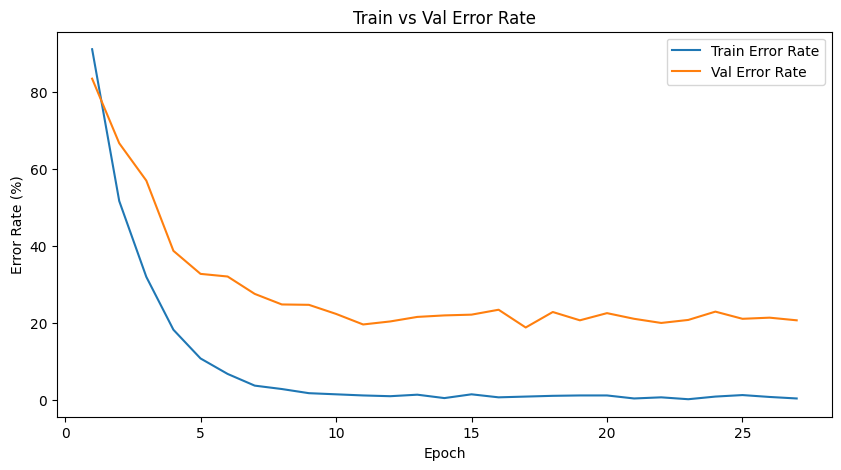

In [15]:
# x 값의 범위를 train_error_rates와 val_error_rates의 길이에 맞게 설정
epochs = range(1, len(train_error_rates) + 1)

# Train Error Rate와 Val Error Rate 그림 그리기
plt.figure(figsize=(10, 5)) 
plt.plot(epochs, train_error_rates, label='Train Error Rate')
plt.plot(epochs, val_error_rates, label='Val Error Rate')
plt.xlabel('Epoch')
plt.ylabel('Error Rate (%)')
plt.title('Train vs Val Error Rate')
plt.legend()
plt.show()


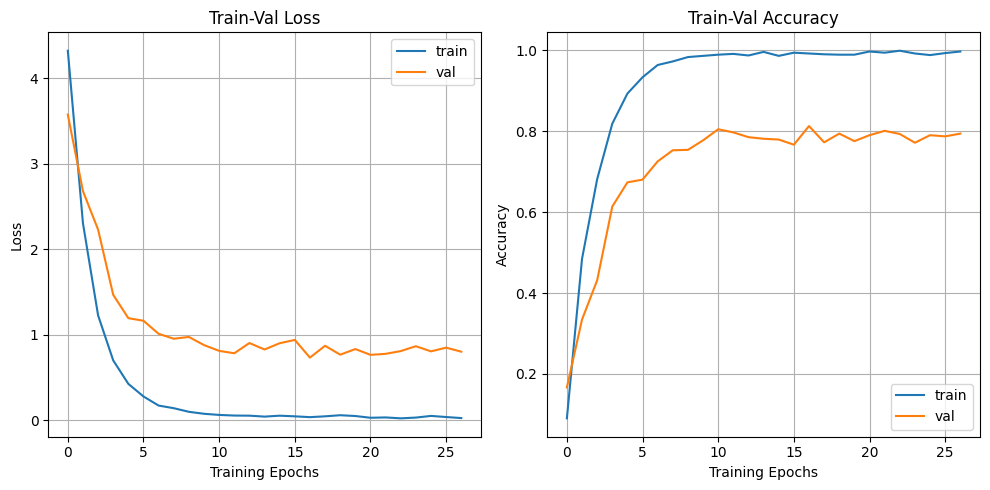

In [16]:
# 손실 그래프
train_losses, val_losses = zip(*loss)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Train-Val Loss')

# 정확도 그래프
train_accuracies, val_accuracies = zip(*accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train-Val Accuracy')

plt.tight_layout()
plt.grid(True)
plt.show()

In [17]:
min_train_error_rate = min(train_error_rates)
min_val_error_rate = min(val_error_rates)

# 최소값 출력
print(f"Minimum Train Error Rate: {min_train_error_rate:.2f}%")
print(f"Minimum Val Error Rate: {min_val_error_rate:.2f}%")

Minimum Train Error Rate: 0.10%
Minimum Val Error Rate: 18.73%


In [18]:
max_train_accuracy = max(train_accuracies)
max_val_accuracy = max(val_accuracies)

# 최고값 출력
print(f"Maximum Train Accuracy: {max_train_accuracy:.2f}%")
print(f"Maximum Val Accuracy: {max_val_accuracy:.2f}%")


Maximum Train Accuracy: 1.00%
Maximum Val Accuracy: 0.81%
